In [1]:
!pip3 install ipywidgets
!pip3 install matplotlib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D


from tqdm.auto import tqdm
sns.set(style='ticks', palette='Set2')
sns.despine()
sns.set_context("talk")

     |████████████████████████████████| 121 kB 20.7 MB/s 
     |████████████████████████████████| 243 kB 44.6 MB/s 
     |████████████████████████████████| 1.6 MB 50.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


<Figure size 1800x1200 with 0 Axes>

In [2]:
def confidence_interval(data, func=np.mean, size=1000, ci=95, seed=12345):
    bs_replicates = sns.algorithms.bootstrap(data, func=func, n_boot=size, seed=seed)
    bounds = sns.utils.ci(bs_replicates, ci)
    return (bounds[1] - bounds[0]) / 2

In [3]:
def sort_key(row):
    keys = {
        'cora': 1, 'pubmed': 2, 'facebook': 3, 'lastfm': 4,     # datasets
        'gcn': 1, 'gat': 2, 'sage': 3,                          # models
        'rnd': 1, '1rnd': 2, 'one': 3, 'ohd': 4, 'raw': 5,      # features
        'mbm': 6, '1bm': 2, 'rbm': 3, 'lpm': 4, 'agm': 5,       # mechanism
    }
    return row.replace(keys)


def aggregate_results(results_path):
    list_csv = [os.path.join(results_path + '/', file) for file in os.listdir(results_path + '/') if file.endswith('.csv')]
    
    columns = ['Name', 'dataset', 'model', 'feature', 'mechanism', 'x_eps', 'y_eps', 'x_steps', 'y_steps', 
               'forward_correction', 'test/acc']
    df = pd.DataFrame()

    for csv_file in tqdm(list_csv):
        df_csv = pd.read_csv(
            csv_file,
            usecols=columns,
        )
        df = df.append(df_csv, ignore_index=True)

    print(df.columns)

    df = df.groupby(list(set(columns) - set(['test/acc']))).agg(
        mean=('test/acc', 'mean'),
        ci=('test/acc', confidence_interval)
    ).reset_index().rename(
        columns=lambda name: f'test/acc_{name}' if name in ['mean', 'ci'] else name
    ).set_index('Name')

    df.to_csv(results_path + '/data.csv')
    df.head()
    return df

def read_logs(results_dir, best_steps=False, **params):
    results_path = results_dir
    try:
        df = pd.read_csv(results_path + '/data.csv', index_col='Name')
    except FileNotFoundError:
        df = aggregate_results(results_path)
    
    if params:
        condition = True
        for param_name, param_val in params.items():
            if isinstance(param_val, list) or isinstance(param_val, tuple):
                condition &= df[param_name].isin(param_val)
            else:
                condition &= df[param_name] == param_val
        df = df[condition]
    
    if best_steps:
        df_steps = pd.read_csv('hparams/steps.csv')
        if 'x_steps' in params:
            df_steps = df_steps.drop(columns=['x_steps'])
        if 'y_steps' in params:
            df_steps = df_steps.drop(columns=['y_steps'])
        df = df.merge(df_steps, how='inner', on=df_steps.columns.to_list())
        
    return df.sort_values(['dataset', 'model', 'feature', 'mechanism', 'x_eps', 'y_eps', 'x_steps', 'y_steps'], key=sort_key)


def export_figure(path, df, x, y, hue=None, row=None, col=None, ci=95, prefix=''):
    if not os.path.exists(path):
        os.makedirs(path)

    tolist = lambda arg: [arg] if arg else []
    group = tolist(row) + tolist(col) + tolist(hue)

    if ci in df.columns:
        output = [x, y, ci]
    elif ci == 'sd':
        df = df.groupby(group + [x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        df = df.groupby(group + [x]).agg(mean=(y, 'mean'),
                                           std=(y, lambda a: confidence_interval(a, ci=ci))).reset_index()
        output = [x, 'mean', 'std']
    
    df['filename'] = df[group].apply(
        lambda record: ','.join(
            ([prefix] if prefix else []) + [f'{key}={val}' for key, val in record.iteritems()]  # + [f'x={x}', f'y={y}']
        ) + '.csv', axis=1
    )
    df.groupby('filename').apply(
        lambda record: record[output].to_csv(
            os.path.join(path, record['filename'].unique().item()),
            index=None,
            sep=','
        )
    )

# 6.1 - K, K-1, K-2 (Best Only) Comparison for Cora

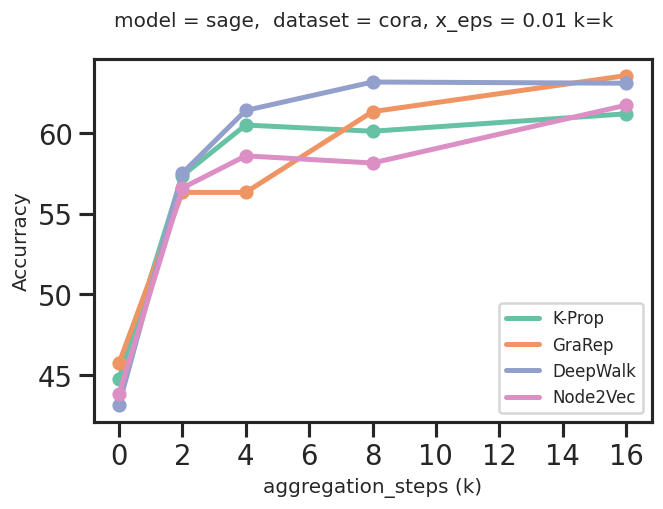

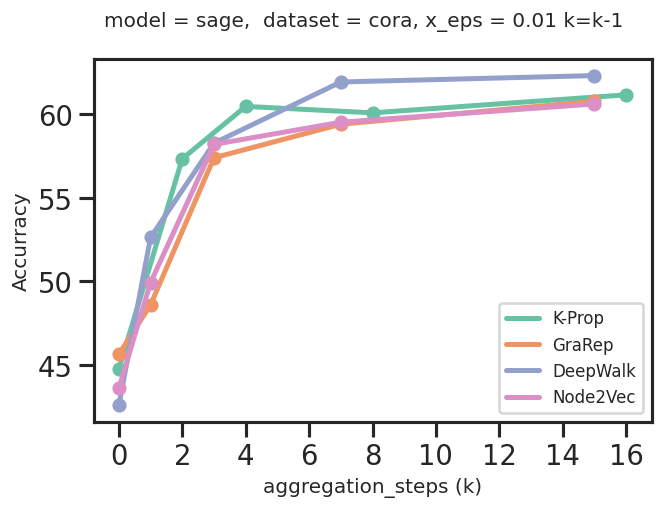

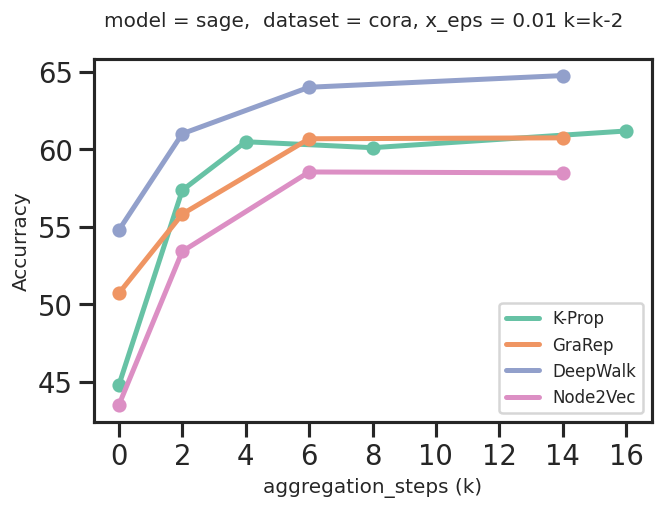

In [51]:
current_model = 'sage'

df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.1/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0002/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.999-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 4, 8, 16]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('model = ' + current_model + ',  dataset = ' + 'cora' + ', x_eps = ' + str(x_ep) + ' k=k', fontsize=12)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k.png')
plt.close()


df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.15/k_1"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0001/k-1"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.999-k-1"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 1, 3, 7, 15]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('model = ' + current_model + ',  dataset = ' + 'cora' + ', x_eps = ' + str(x_ep) + ' k=k-1', fontsize=12)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k-1.png')
plt.close()



df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.1/k_2"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0002/k-2"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.999-k-2"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 6, 14,]
grarep_y = grarep['test/acc_mean'].tolist()
grarep_y = grarep_y[1:]
deepwalk_y = deepwalk['test/acc_mean'].tolist()
deepwalk_y = deepwalk_y[1:]
node2vec_y = node2vec['test/acc_mean'].tolist()
node2vec_y = node2vec_y[1:]


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('model = ' + current_model + ',  dataset = ' + 'cora' + ', x_eps = ' + str(x_ep) + ' k=k-2', fontsize=12)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k-2.png')
plt.close()






# Effect of threshold (Cora)

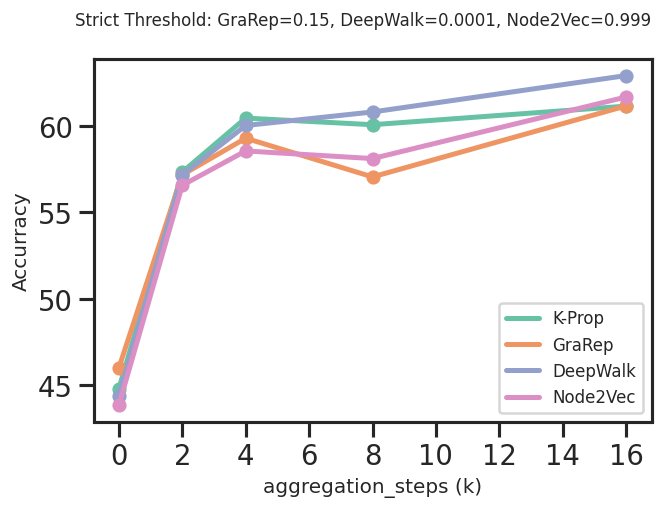

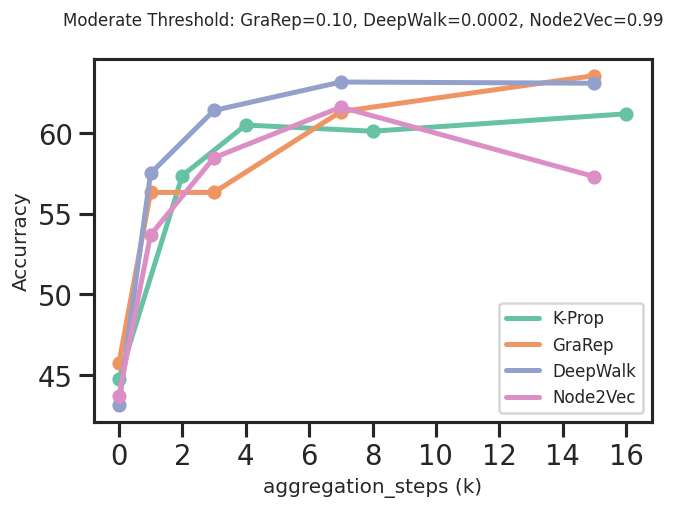

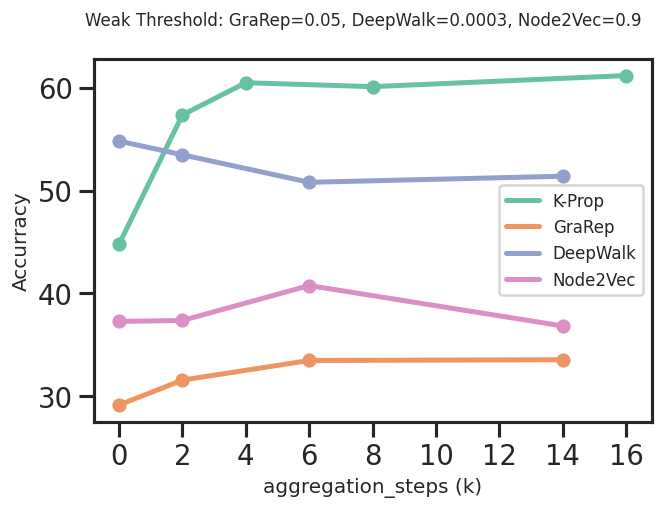

In [55]:
current_model = 'sage'

df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.15/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0001/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.999-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 4, 8, 16]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('Strict Threshold: GraRep=0.15, DeepWalk=0.0001, Node2Vec=0.999', fontsize=10)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k.png')
plt.close()


df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.1/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0002/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.99-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 1, 3, 7, 15]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('Moderate Threshold: GraRep=0.10, DeepWalk=0.0002, Node2Vec=0.99', fontsize=10)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k-1.png')
plt.close()



df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.05/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0003/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.9-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 6, 14,]
grarep_y = grarep['test/acc_mean'].tolist()
grarep_y = grarep_y[1:]
deepwalk_y = deepwalk['test/acc_mean'].tolist()
deepwalk_y = deepwalk_y[1:]
node2vec_y = node2vec['test/acc_mean'].tolist()
node2vec_y = node2vec_y[1:]


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('Weak Threshold: GraRep=0.05, DeepWalk=0.0003, Node2Vec=0.9', fontsize=10)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()
plt.savefig('graphs/k-2.png')
plt.close()






# LastFM vs Cora 

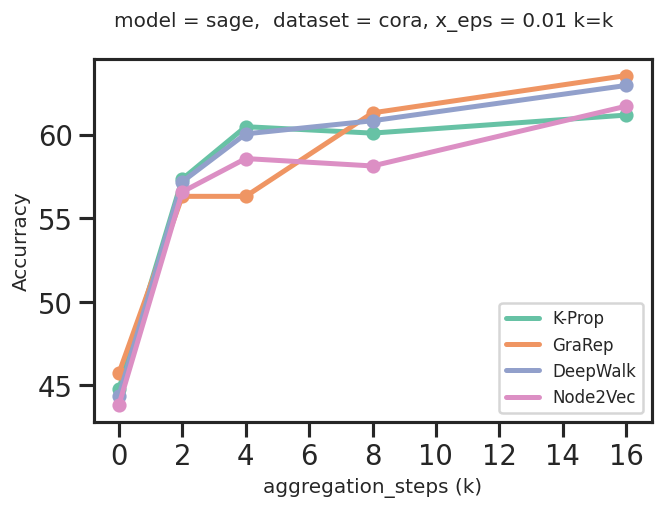

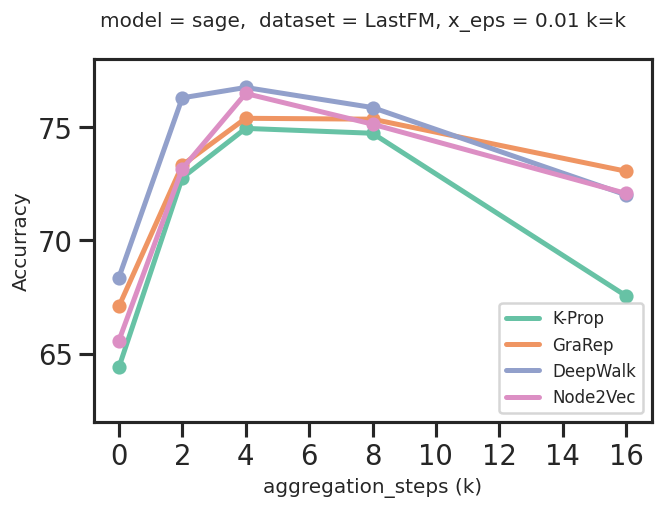

In [75]:
current_model = 'sage'

df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/cora/0.1/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/cora/0.0001/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/cora-0.999-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/cora"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 4, 8, 16]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('model = ' + current_model + ',  dataset = ' + 'cora' + ', x_eps = ' + str(x_ep) + ' k=k', fontsize=12)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
# plt.ylim(42,72)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()


df_grarep = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/grarep/lastfm/0.1/k"
)


df_deepwalk = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/deepwalk/lastfm/0.00008/k"
)

df_node2vec = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/node2vec/lastfm-0.999-k"
)


df_baseline = read_logs(
    model=current_model, 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True,
    results_dir = "all_results/kprop/lastfm"
)





x_eps = [0.01]

colors = ['#67C2A5', "#EF9563", "#92A0CB", "#DC8FC4"]
# colors = ['#67C2A5', "#92A0CB"]


grarep = df_grarep[(df_grarep['model'] == current_model) & (df_grarep['x_eps'] == x_ep)]
deepwalk = df_deepwalk[(df_deepwalk['model'] == current_model) & (df_deepwalk['x_eps'] == x_ep)]
node2vec = df_node2vec[(df_node2vec['model'] == current_model) & (df_node2vec['x_eps'] == x_ep)]
kprop = df_baseline[(df_baseline['model'] == current_model) & (df_baseline['x_eps'] == x_ep)]

kprop_x = [0, 2, 4, 8, 16]
kprop_y = kprop['test/acc_mean'].tolist()

simgat_x = [0, 2, 4, 8, 16]
grarep_y = grarep['test/acc_mean'].tolist()
deepwalk_y = deepwalk['test/acc_mean'].tolist()
node2vec_y = node2vec['test/acc_mean'].tolist()


plt.plot(kprop_x, kprop_y, marker='.', color=colors[0], linewidth=3, markersize=15)
plt.plot(simgat_x, grarep_y, marker='.', color=colors[1], linewidth=3, markersize=15)
plt.plot(simgat_x, deepwalk_y, marker='.', color=colors[2], linewidth=3, markersize=15)
plt.plot(simgat_x, node2vec_y, marker='.', color=colors[3], linewidth=3, markersize=15)


plt.suptitle('model = ' + current_model + ',  dataset = ' + 'LastFM' + ', x_eps = ' + str(x_ep) + ' k=k', fontsize=12)

plt.xlabel('aggregation_steps (k)', fontsize=12)
plt.ylabel('Accurracy', fontsize=12)


plt.xticks(np.arange(0, 17, 2))
plt.ylim(62 ,78, 5)


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['K-Prop', 'GraRep', 'DeepWalk', 'Node2Vec']
plt.legend(lines, labels, fontsize=10)

plt.gcf().set_dpi(120)
plt.show()






<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=978ef357-52a0-45d9-99d4-193950f10e8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>